# Comparing Total Gas Masses Between Analyses - LoCuSS High-$L_{\rm{X}}$

This notebook measures gas masses for the LoCuSS High-$L_{\rm{X}}$ sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample File and Declaring XGA ClusterSample

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [00:11<00:24,  1.33it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [00:14<00:20,  1.31it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  50%|██████████████████████                      | 25/50 [00:15<00:12,  1.97it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source RXCJ1212.3-1816 does not appear to have any XMM dat

## Running PSF Correction

In [4]:
rl_psf(locuss_srcs)

Generating products of type(s) image: 100%|███████████████████████████████████| 45/45 [00:03<00:00, 13.28it/s]


## Reading in literature data

### Gas masses from literature

In [5]:
loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gm2500s = [locuss[locuss['name'] == n].iloc[0][['x_mg2500', 'x_mg2500_err', 'x_mg2500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')
loc_lit_gm2500s = Quantity(loc_lit_gm2500s, 'Msun')

### Conversion Temperatures

In [6]:
loc_conv_txs = []
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [7]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [8]:
loc_beta_13_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 45/45 [00:18<00:00,  2.50it/s]
Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [17:34<00:00, 23.43s/it]


In [9]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [10]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [25:24<00:00, 33.88s/it]


In [11]:
loc_beta_king_13_gm500 = []
loc_beta_king_13_gm2500 = []

with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_13_gm500.append(gm)
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r2500)[0]
            loc_beta_king_13_gm2500.append(gm)
        else:
            loc_beta_king_13_gm2500.append([np.NaN, np.NaN, np.NaN])
            loc_beta_king_13_gm500.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)               
        
loc_beta_king_13_gm500 = Quantity(loc_beta_king_13_gm500, 'Msun')
loc_beta_king_13_gm2500 = Quantity(loc_beta_king_13_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [01:39<00:00,  2.21s/it]


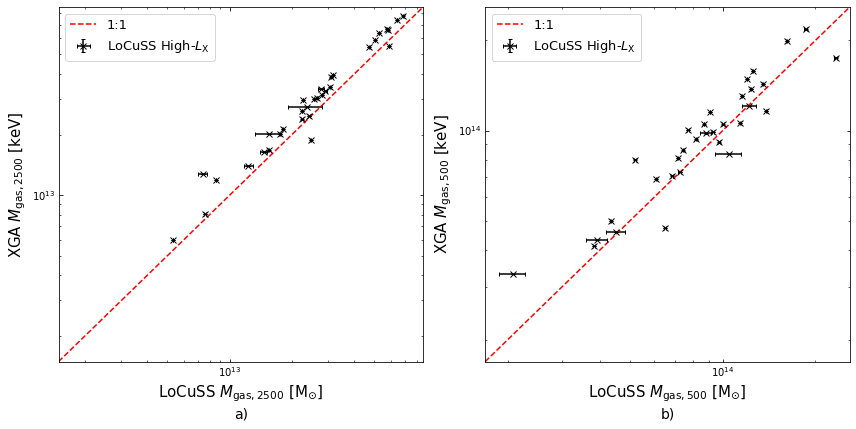

In [12]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_beta_king_13_gm2500, loc_beta_king_13_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [13]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [14]:
loc_dblbeta_13_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/45 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1173.47593901  507.28647662 1064.98452424  915.68331001  987.35791156
 1020.59381788]


Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/45 [00:26<19:18, 26.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [565.76430631 354.05305086 386.37277485 303.44837007 304.36985304
 345.92708173]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/45 [01:20<18:36, 26.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1221.79722081  518.10571131 1157.52980047  768.59896026  851.9184048
 1013.06648901]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/45 [01:44<17:23, 25.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1101.77927412 1328.01449327 1559.48659108 1129.66200086 1304.69787226
 1488.31638798]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▉       | 5/45 [02:09<16:52, 25.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [222.82755663 415.96780247 144.34456895 146.26575423 219.17589244
 304.05041821]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 6/45 [02:34<16:28, 25.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [142.05871089 382.09460273 403.31209152 300.22957566 354.89055329
 430.47142799]


Fitting data, inverse Abel transforming, and measuring densities:  16%|█▏      | 7/45 [03:02<16:33, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 494.38660894  167.50703403 1943.97289238 1900.69982426 1964.97824031
 1896.11875318]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 13/45 [05:43<14:06, 26.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1425.15108213 1582.91539412 1872.93457747 1709.03954914 1810.5538575
 1977.56274941]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1106.99016398  404.18452146  863.82557454  758.18490822  872.7633475
  884.1681316 ]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/45 [06:36<13:14, 26.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [561.59217612 544.73884311 341.46819719 369.68011637 431.23562175
 557.99847388]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 754.797892    821.91446076 1030.63556716  853.29717201  981.0203906
 1058.50119537]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▍    | 16/45 [07:02<12:45, 26.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 536.38746996  394.00689987 1736.54738714 1211.70100982 1266.39015936
 1458.52533636]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 18/45 [07:51<11:23, 25.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1735.62392528  406.19925926 2199.66318069  947.06315975 1190.82724622
 2196.1203792 ]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 22/45 [09:47<10:48, 28.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1757.26876716  390.36967995 2240.19292366 1766.8799879   337.91581813
 2174.66829204]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 23/45 [10:13<10:00, 27.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1221.36067135  820.91890329 2366.14377863 1187.55018133 1622.52217715
 2305.63268977]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 25/45 [11:10<09:30, 28.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1949.1615195   252.31284675 2162.65163953  517.48237819  462.17510098
 2162.51427316]


Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 26/45 [11:33<08:31, 26.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 332.63304065  419.11595945 1369.12607432 1008.46244641  613.62910167
  404.20641842]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 32/45 [14:20<05:53, 27.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 817.79814901  616.43064918 1873.34823657 1448.01336379 1575.44576203
 1875.37420707]


Fitting data, inverse Abel transforming, and measuring densities:  73%|█████▏ | 33/45 [14:45<05:20, 26.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [842.6624967  717.70003446 790.77146394 921.85800713 894.93083535
 795.19221044]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 35/45 [15:42<04:37, 27.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [202.15550522 344.28785819 433.8000696  374.09045971 411.2192867
 437.69069065]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 42/45 [18:59<01:22, 27.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1262.84210918  824.69167891 1026.35783637  747.87375699  899.0753419
 1097.01174657]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 43/45 [19:27<00:54, 27.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [479.36737221 421.88772165 442.81254426 326.57616771 384.79978586
 476.50331748]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 44/45 [19:51<00:26, 26.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 983.56086381  936.95225869 1555.70194622 1118.88573675 1407.51167179
 1520.15636373]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [20:16<00:00, 27.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 656.53202195  250.66323028 1618.00361722 1344.47273593 1208.65772392
 1605.85738425]


In [15]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [16]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:  13%|████▎                           | 6/45 [04:18<27:16, 41.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 100.07499845  106.08487031 1079.65335142  107.97950559  124.35690577
  103.24070175]


Fitting density model to LoCuSS profiles:  18%|█████▋                          | 8/45 [05:49<26:55, 43.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [100.44395938 100.10316819 613.78226806  98.95316509 130.02936969
 101.49497063]


Fitting density model to LoCuSS profiles:  22%|██████▉                        | 10/45 [07:18<25:49, 44.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 78.87526954  80.91094449 637.36395557  78.76150276  82.35726529
  87.07054849]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [08:01<24:54, 43.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2417.93970572 2434.4472973   946.30911243 1182.75211432 2434.17542871
 1004.04516084]


Fitting density model to LoCuSS profiles:  29%|████████▉                      | 13/45 [09:28<23:19, 43.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 345.38885413  523.70304929 1095.04109825  280.62971527  202.03783294
  622.03222325]


Fitting density model to LoCuSS profiles:  36%|███████████                    | 16/45 [11:40<21:19, 44.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2421.04399584 2361.29824098 1809.65032888 2216.43600474 1079.12307457
 2081.17476872]


Fitting density model to LoCuSS profiles:  40%|████████████▍                  | 18/45 [13:05<19:19, 42.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1661.36208505 1680.69482189  786.67659479 1265.28655578 1559.35439368
  926.7090194 ]


Fitting density model to LoCuSS profiles:  47%|██████████████▍                | 21/45 [15:22<17:52, 44.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [101.55249787 101.11702722 696.97602311 103.04194786 122.58192755
 101.58809337]


Fitting density model to LoCuSS profiles:  49%|███████████████▏               | 22/45 [16:04<16:50, 43.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [109.27467154 109.55372558 689.76111524  97.33809851 113.48376997
  87.1061853 ]


Fitting density model to LoCuSS profiles:  58%|█████████████████▉             | 26/45 [19:16<14:41, 46.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1472.55465776 1553.57034599  886.39515911 1461.93435292 1449.77657533
  977.99190501]


Fitting density model to LoCuSS profiles:  67%|████████████████████▋          | 30/45 [22:21<11:28, 45.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  92.35481866   92.93155521 1120.27510892  108.43916404  113.07244946
   94.63607807]


Fitting density model to LoCuSS profiles:  71%|██████████████████████         | 32/45 [23:50<09:41, 44.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [835.78751463 788.98944489 459.09354946 626.36081601 321.23553178
 449.44942221]


Fitting density model to LoCuSS profiles:  73%|██████████████████████▋        | 33/45 [24:41<09:17, 46.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 65.66049807  72.15494635 727.9691353   84.0776806   86.86676429
  44.56338135]


Fitting density model to LoCuSS profiles:  76%|███████████████████████▍       | 34/45 [25:28<08:32, 46.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [480.03199172 855.44500176 942.19556685 226.96565528 154.78188471
 915.16537736]


Fitting density model to LoCuSS profiles:  91%|████████████████████████████▏  | 41/45 [31:17<03:13, 48.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 79.16446806  83.74692345 626.50675407  83.13291736  87.05298864
  92.46914297]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 42/45 [31:59<02:19, 46.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [118.63877421 146.66524735 631.28438372 111.2396409  129.762446
 164.57360526]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [34:17<00:00, 45.71s/it]


In [17]:
loc_dblbeta_svikh_13_gm500 = []
loc_dblbeta_svikh_13_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_13_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_13_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_13_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_13_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_13_gm500 = Quantity(loc_dblbeta_svikh_13_gm500, 'Msun')
loc_dblbeta_svikh_13_gm2500 = Quantity(loc_dblbeta_svikh_13_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [07:22<00:00,  9.84s/it]


In [18]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_13_gm2500[:, 0]).sum(), t=len(loc_dblbeta_svikh_13_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_13_gm500[:, 0]).sum(), t=len(loc_dblbeta_svikh_13_gm500)))

45 out of 45 R2500 gas mass measurements produced a result
45 out of 45 R500 gas mass measurements produced a result


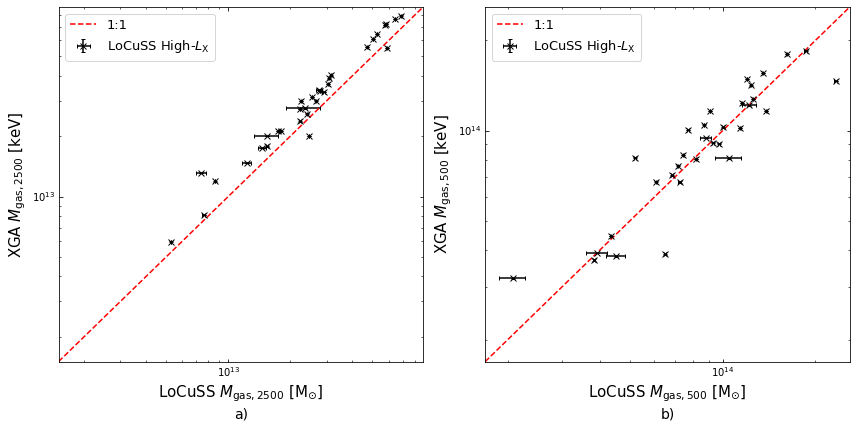

In [19]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_13_gm2500, loc_dblbeta_svikh_13_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath='../../outputs/figures/locuss_13r500_gmcomp_dblbeta_svikh.pdf')

In [20]:
loc_dblbeta_svikh_13_gm500.shape

(45, 3)

### Double Beta and Simplified Vikhlinin Profiles - out to 1.1$R_{500}$

In [21]:
loc_dblbeta_11_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.1, 
                                       conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/45 [00:25<18:39, 25.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1188.47372901  848.84500208 1172.39722947 1146.35195836 1218.90574447
 1129.44372494]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 2/45 [00:53<19:08, 26.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [566.22986795 472.00773824 465.99458559 450.04991204 449.01484997
 493.58187849]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/45 [01:17<17:51, 25.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1708.38999927  857.34813581 1935.00252317 1667.76061496 1820.93312392
 1873.78704758]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/45 [01:39<16:31, 24.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 720.57057959 2215.77075149 2183.59793517 2248.46423264 2306.07791882
 2305.31246239]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▉       | 5/45 [02:03<16:08, 24.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [443.29302063 625.44693013 269.66973838 150.4756185  251.73037183
 299.30235532]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 6/45 [02:28<15:54, 24.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 242.37619599 1030.2651002   840.39487641  725.9795941   777.95008506
  873.32437419]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▍      | 8/45 [03:19<15:22, 24.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 367.19920737  658.29163094 1872.38810699 1845.6801595  1897.37703662
 1858.93545748]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 11/45 [04:39<14:34, 25.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [672.37648349 642.16960649 633.33282623 599.32751163 605.73453112
 669.45040062]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 13/45 [05:31<13:46, 25.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1382.8573829   674.70966319 1442.95257374 1705.22863979 1728.58366611
 1490.826662  ]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 14/45 [05:59<13:33, 26.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1341.00102144  365.78606084 1249.40691921 1030.18708058 1164.62713628
 1222.10299514]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/45 [06:24<13:02, 26.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1071.53311237 1076.15138313  973.39748539  905.77275195 1001.12334646
 1123.36363575]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▍    | 16/45 [06:50<12:30, 25.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 942.54576349  924.28821868 1268.37740955 1123.06539234 1227.10195061
 1336.90137714]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 17/45 [07:15<12:03, 25.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 507.86062736  382.58296843 1695.9682367  1236.37021955 1315.66124469
 1467.34253218]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 18/45 [07:39<11:17, 25.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 257.75367835 1046.79766837 1999.07612812 2401.78642099 2373.5938198
 1927.9582726 ]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 22/45 [09:32<10:36, 27.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1097.91920838  326.7892009  1829.24630827 1653.52226925 1418.22090853
 1835.7463478 ]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 24/45 [10:21<09:05, 25.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 857.76287978  751.60996461 2091.15424079 1519.96676747 1799.77342421
 2016.11849781]


Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 26/45 [11:13<08:09, 25.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1345.52771562  412.2799601  2224.21120091  967.9153851  1151.18138865
 2221.33067913]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 27/45 [11:39<07:46, 25.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 599.89662168  706.07832379 1293.57208778 1076.18011666  834.56818969
  793.53749798]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 32/45 [13:53<05:39, 26.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 856.55356038  849.51979001 1745.11762665 1476.09190106 1441.27344061
 1745.97237236]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 34/45 [14:44<04:45, 25.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1274.77212039  916.19752843 1165.92701197 1081.46551797 1144.67608961
 1222.92995472]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 35/45 [15:13<04:28, 26.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [295.71367954 559.7814774  580.15631732 432.92237631 468.74559738
 565.47807598]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 42/45 [18:23<01:20, 26.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1337.46925348  703.81923186 1317.43574625 1077.38946413 1200.65305316
 1377.59464913]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 43/45 [18:50<00:53, 26.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [364.34991698 330.35645425 418.63620266 267.89290814 342.76245821
 443.59487626]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 44/45 [19:13<00:25, 25.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 870.95925062  827.49783669 1582.03175244 1455.56594442 1545.12310784
 1561.20214101]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 45/45 [19:37<00:00, 26.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [373.73157163 633.68421297 792.71494215 627.38748538 727.54199978
 962.16696654]


In [22]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_11_dp)) as onwards:
    for dp in loc_dblbeta_11_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:   2%|▋                               | 1/45 [00:42<31:18, 42.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [113.19663478 144.96895723 969.96492444 110.23342588 109.05313613
 342.94027587]


Fitting density model to LoCuSS profiles:   7%|██▏                             | 3/45 [02:10<30:11, 43.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 127.36318405  204.11083735 1042.26228095  123.62206853  121.98954463
  625.58492859]


Fitting density model to LoCuSS profiles:  11%|███▌                            | 5/45 [03:32<27:54, 41.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [117.81033261 208.06072493 652.14434028 116.63261642 111.90566393
 226.24326342]


Fitting density model to LoCuSS profiles:  13%|████▎                           | 6/45 [04:10<26:25, 40.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [112.59000698 115.02273871 966.27698593 112.79923518 110.52750953
 108.32021805]


Fitting density model to LoCuSS profiles:  16%|████▉                           | 7/45 [04:56<26:53, 42.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [579.78132069 805.89021624 766.08224287 384.01819265 584.75381156
 891.35907172]


Fitting density model to LoCuSS profiles:  22%|██████▉                        | 10/45 [07:05<25:02, 42.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 85.52857901  88.87237298 745.91904094  84.42439786  81.0078075
  89.86319844]


Fitting density model to LoCuSS profiles:  24%|███████▌                       | 11/45 [07:47<24:09, 42.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2011.85273586 2081.11204072 1020.57458227 1609.58368746 1920.44315325
 1068.03899472]


Fitting density model to LoCuSS profiles:  29%|████████▉                      | 13/45 [09:11<22:33, 42.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [431.05023653 697.54039874 841.39829138 286.56158346 166.49686172
 779.96276018]


Fitting density model to LoCuSS profiles:  33%|██████████▎                    | 15/45 [10:34<20:51, 41.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 97.83649285 115.8577396  678.72755184 116.35465463 124.73721449
 127.08370299]


Fitting density model to LoCuSS profiles:  36%|███████████                    | 16/45 [11:17<20:26, 42.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2471.18637752 2439.51427128 2070.90693262 2239.79307173 1583.54320393
 2266.49431379]


Fitting density model to LoCuSS profiles:  40%|████████████▍                  | 18/45 [12:41<18:55, 42.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1700.86640836 1684.8472986   356.08766806  658.48470387 1703.49421839
  416.98997899]


Fitting density model to LoCuSS profiles:  42%|█████████████                  | 19/45 [13:26<18:31, 42.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 86.77140901  86.80476577 668.90498388  86.02049374  82.60290338
  86.19677544]


Fitting density model to LoCuSS profiles:  47%|██████████████▍                | 21/45 [14:55<17:22, 43.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 96.58975975  96.92749237 601.91847324  99.19415294 136.64318565
  95.59746169]


Fitting density model to LoCuSS profiles:  58%|█████████████████▉             | 26/45 [18:36<14:05, 44.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1846.28657052 1850.69761251  699.61471402 1603.11683486 1803.77615122
  831.35684966]


Fitting density model to LoCuSS profiles:  60%|██████████████████▌            | 27/45 [19:20<13:14, 44.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [100.07638167 100.61789903 650.86613634 110.67961761 118.44758654
 101.19796438]


Fitting density model to LoCuSS profiles:  67%|████████████████████▋          | 30/45 [21:33<10:57, 43.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 97.08034711  95.30512974 865.78581087 107.37840574 119.71447782
  91.54352065]


Fitting density model to LoCuSS profiles:  71%|██████████████████████         | 32/45 [23:04<09:37, 44.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1734.35698552 2098.02281467  714.24042802 1879.47551785 1623.84970567
 1342.13999666]


Fitting density model to LoCuSS profiles:  73%|██████████████████████▋        | 33/45 [23:52<09:06, 45.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 59.31155843  60.83501072 766.065122    85.87433497  89.24719068
  33.96785973]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 42/45 [30:50<02:14, 44.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 390.54540777  724.36226269 1116.87248259  210.70423942  143.11201229
  840.31738891]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 45/45 [33:02<00:00, 44.05s/it]


In [23]:
loc_dblbeta_svikh_11_gm500 = []
loc_dblbeta_svikh_11_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_11_dp)) as onwards:
    for dp in loc_dblbeta_11_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_11_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_11_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_11_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_11_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_11_gm500 = Quantity(loc_dblbeta_svikh_11_gm500, 'Msun')
loc_dblbeta_svikh_11_gm2500 = Quantity(loc_dblbeta_svikh_11_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 45/45 [07:22<00:00,  9.83s/it]


In [24]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_11_gm2500[:, 0]).sum(), t=len(loc_dblbeta_svikh_11_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_11_gm500[:, 0]).sum(), t=len(loc_dblbeta_svikh_11_gm500)))

45 out of 45 R2500 gas mass measurements produced a result
45 out of 45 R500 gas mass measurements produced a result


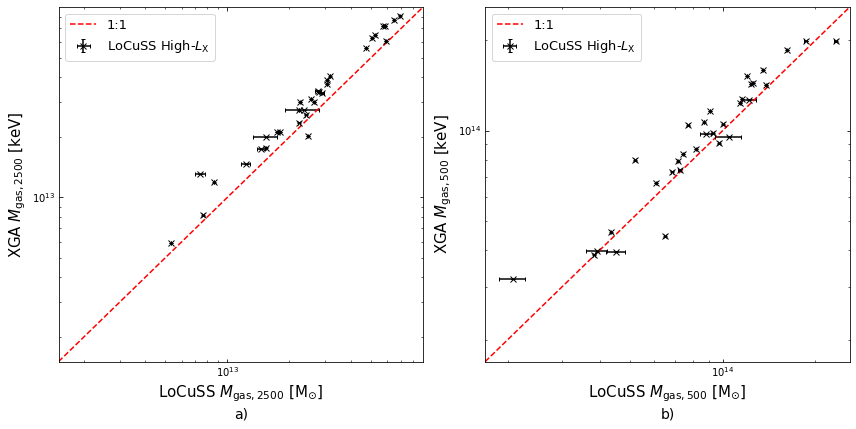

In [25]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_11_gm2500, loc_dblbeta_svikh_11_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'